# 10 — Model Interpretability with SHAP

Understanding *why* a model makes predictions is as important as the predictions themselves.
We use SHAP to identify which features impact the model most and in what direction.


Step 1 — Imports

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier


Step 2 — Load & Split Data

In [3]:
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)
df = df.drop(columns=["Cabin", "Ticket", "Name", "PassengerId"])

X = df.drop(columns=["Survived"])
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Step 3 — Recreate the Preprocessing Pipeline

In [4]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


Step 4 — Now Create the Final Model Pipeline

In [5]:
best_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=1,
        random_state=42
    ))
])

best_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Once the model trains successfully, we proceed to SHAP:

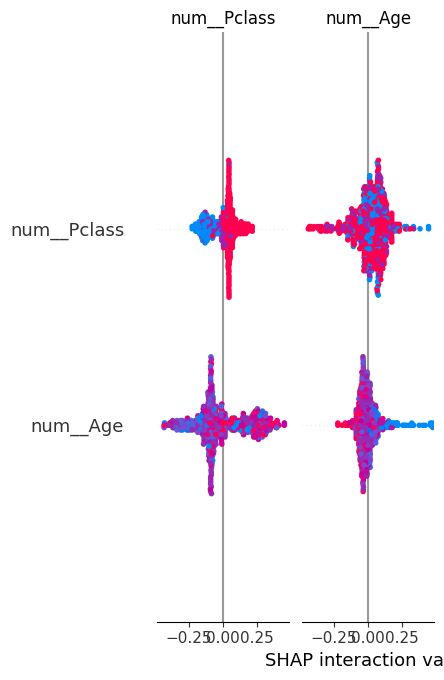

In [10]:
import shap
import numpy as np

X_processed = best_model.named_steps["preprocess"].transform(X_train)

if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()

explainer = shap.Explainer(best_model.named_steps["model"])

shap_values = explainer(X_processed)

shap.summary_plot(shap_values.values, X_processed, 
                  feature_names=best_model.named_steps["preprocess"].get_feature_names_out())


In [15]:
import numpy as np

shap_class1 = shap_values.values[..., 1]

mean_abs_shap = np.abs(shap_class1).mean(axis=0)

feature_names = best_model.named_steps["preprocess"].get_feature_names_out()

importance_sorted = sorted(zip(feature_names, mean_abs_shap), key=lambda x: x[1], reverse=True)

importance_sorted[:5]
[(f, round(v, 3)) for f, v in importance_sorted[:5]]


[('cat__Sex_male', np.float64(0.118)),
 ('cat__Sex_female', np.float64(0.105)),
 ('num__Pclass', np.float64(0.078)),
 ('num__Fare', np.float64(0.068)),
 ('num__Age', np.float64(0.054))]

| Feature        | Meaning                                              | Effect                       |
| -------------- | ---------------------------------------------------- | ---------------------------- |
| **Sex_male**   | Being male **reduces survival probability** the most | **Strong negative effect**   |
| **Sex_female** | Being female **increases survival probability**      | Strong protective effect     |
| **Pclass**     | Lower class ticket = **worse chance**                | Strong socio-economic factor |
| **Fare**       | Higher fare = **better chance**                      | Wealth → access → rescue     |
| **Age**        | Younger passengers survived more                     | Expected but weaker effect   |
